# E-commerce — Анализ товарного ассортимента

**Цель проекта:** провести анализ товарного ассортимента интернет-магазина товаров для дома и быта.

Для достижения цели нужно выполнить следующие задачи:
- провести исследовательский анализ данных;
- проанализировать торговый ассортимент;
- выявить типичные сегменты потребителей;
- выдвинуть и проверить статистические гипотезы.

**Материалы**

[Презентация](https://drive.google.com/file/d/1TW2m1Oqr7nXLsaORsXazNJ0UyAPNnBjy/view?usp=sharing)

[Дашборд](https://public.tableau.com/profile/elizaveta6432#!/vizhome/E-commerce_16214574832710/E-commerce?publish=yes)

## Загрузка данных

Перед началом исследования загрузим необходимые для работы библиотеки и компоненты.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymystem3 import Mystem
from io import BytesIO
import requests
from functools import reduce
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

#проверка версии сиборн
if sns.__version__ == '0.11.1':
    print(sns.__version__)
else:
    !pip install seaborn==0.11.1

0.11.1


Теперь загрузим данные и сохраним в переменной df. Выведем первые пять строк датасета.

In [2]:
data = pd.read_csv('/datasets/ecommerce_dataset.csv')
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Первичный взгляд на таблицу дает понять, что данные в столбце `date` необходимо преобразовать к читаемому виду. Также для дальнейшей работы лучше привести к нижнему регистру столбец `product`, чтобы удобнее работать с ним.

Теперь отобразим основную информацию о датасете методом `info()`.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В таблице 6737 строк и 6 столбцов со следующими данными в столбцах:

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

Пропусков в таблице нет. Необходимо поменять тип данных в столбце с датой.

**Вывод**

В переменную `data` был загружен датасет с информацией о транзакциях интернет-магазина товаров для дома и быта. В нем есть данные по покупателю, заказу, товару и его количеству, а также цена. Первичный анализ показал, что в таблице нужно заменить тип данных в столбце `date` и привести к нижнему регистру названия товаров.

## Исследовательский анализ данных

Сначала поменяем тип данных в столбце с датой и приведем к нижнему регистру столбец `product`.

In [4]:
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d%H')
data['product'] = data['product'].str.lower()
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0


Выделим дни недели и сезон. 

In [5]:
# выделим дни недели, затем переведем числа в привычный день недели
data['weekday_number'] = data.date.dt.weekday

# переведем числа в буквы (день недели)
data['weekday'] = data['weekday_number'].replace({0:'Понедельник', 1:'Вторник', 2:'Среда', 3:'Четверг', 
                                           4:'Пятница', 5:'Суббота', 6:'Воскресенье'})
# выделим сезон покупки
data['season'] = data.date.dt.month.replace([12,1,2], 'Зима').replace([3,4,5], 'Весна')\
.replace([6,7,8], 'Лето').replace([9,10,11], 'Осень')

data.head(10)

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,Понедельник,Осень
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,0,Понедельник,Осень
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,Понедельник,Осень
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,Понедельник,Осень
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,Понедельник,Осень
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,0,Понедельник,Осень
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,0,Понедельник,Осень
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,0,Понедельник,Осень
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,0,Понедельник,Осень
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,0,Понедельник,Осень


Проанализируем данные на дубликаты.

In [6]:
data.duplicated().sum()

0

Полных дубликатов нет. Попробуем удалить столбец с датой и снова проверить дубликаты.

In [7]:
data_duplicate = data.drop('date', axis=1)
data_duplicate.duplicated().sum()

1210

Получается в таблице 1 210 дубликатов. Это 18% от общего числа строк, что довольно много. Посмотрим на эти строки. Для этого создадим столбец `duplicate`, в котором будет указано значение `True` для дубликатов, затем отфильтруем по нему.

In [8]:
data['duplicate'] = data_duplicate.duplicated()
data_filltred = data[data['duplicate'] == True]
data_filltred.head(15)

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,1,Вторник,Осень,True
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,1,Вторник,Осень,True
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0,3,Четверг,Осень,True
126,2018-10-07 17:00:00,ce0e0c29-8c8b-4714-84bd-80957224d4cf,68557,сумка-тележка хозяйственная gimi market синяя,1,1874.0,6,Воскресенье,Осень,True
147,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 15,0 л пищевой овальный ""ekk...",1,209.0,0,Понедельник,Осень,True
148,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 18,0 л пищевой (иж), 1404047",1,194.0,0,Понедельник,Осень,True
149,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 20,0 л пищевой (минеральные ...",1,277.0,0,Понедельник,Осень,True
150,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 24,0 л пищевой круглый (иж),...",1,239.0,0,Понедельник,Осень,True
281,2018-10-17 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,щетка для посуды *мила* sv3182 1807009,50,27.0,2,Среда,Осень,True
282,2018-10-17 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,"щетка-утюжок с ручкой миди, standart, york, g1126",50,44.0,2,Среда,Осень,True


Интересно, что первые две строки дублируют друг друга с разницой всего 1 час. Обычно человеку редко нужны больше одной гладильной доски. 

Начиная со строки 147 следующая ситуация: пользователь купил в 19 часов 4 разных таза, а затем через 11 часов снова. Уже похоже на закономерность. Попробуем сгруппировать данные по номеру заказа и дате.

In [9]:
data_grouped = data_filltred.groupby(['order_id', 'date']).agg({'customer_id':'count'})
data_grouped.head(20)

customer_id
order_id date                            
13547    2018-11-02 14:00:00            3
         2018-11-16 16:00:00            3
14500    2018-10-28 09:00:00            9
         2018-10-31 13:00:00            8
14521    2019-01-10 18:00:00            3
         2019-01-27 11:00:00            3
14541    2019-02-17 13:00:00            7
         2019-02-24 12:00:00            5
14566    2019-03-07 11:00:00            4
14570    2019-03-12 19:00:00            3
14601    2019-03-30 18:00:00            4
14649    2019-04-16 16:00:00           13
14664    2019-04-19 22:00:00            3
14753    2019-05-13 15:00:00           30
14795    2019-05-19 18:00:00            6
14833    2019-05-31 16:00:00           12
         2019-06-01 20:00:00           12
         2019-06-01 22:00:00           12
         2019-06-02 08:00:00           12
         2019-06-02 10:00:00           12

Рассмотрим подробнее заказ с `order_id = 13547`.

In [10]:
data[data['order_id']==13547]

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315.0,4,Пятница,Осень,False
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207.0,4,Пятница,Осень,False
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162.0,4,Пятница,Осень,False
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315.0,1,Вторник,Осень,False
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207.0,1,Вторник,Осень,False
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162.0,1,Вторник,Осень,False
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315.0,6,Воскресенье,Осень,False
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207.0,6,Воскресенье,Осень,False
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162.0,6,Воскресенье,Осень,False
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315.0,4,Пятница,Осень,True


И снова заказ полностью повторяется, но уже с разницей в несколько дней. Можно предположить, что покупатель повторяет свой первый заказ. Что довольно странно: пусть первая покупка (05.10.2018) была взята на пробу, дальше, если эксперимент прошел успешно, логичнее было купить сразу нужно количество рассады.

Возможно, что транзакция за заказ проходит не один раз. Тут могут быть разные причины: ошибка или некорректная работа со стороны банка клиента, ошибка при фиксировании события оплаты, списание денег два раза со счета клиента. Также возможно, что это возврат заказа и в выгрузке нет соответствующей отметки об этом. Также есть вероятность, что в выгрузку могли попасть результаты тестирования коллег из отдела разработки.

Возможно, что в таблицу попали данные о движении заказа: от склада до курьера, от курьера до места выдачи и т.д.

В любом случае, стоит составить баг-репорт и подойти к коллегам из отдела эксплуатации/разработки, чтобы посмотреть что и как они фиксируют.

Поскольку для дальнейшего анализа дубликаты могу помешать, то удалим их из датасета.

In [11]:
data_new = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'], keep='first')
data_new.shape

(4873, 10)

Дальше будем работать с таблицей `data_new`. Посмотрим на распределение данных в столбце `price`.

In [12]:
data_new['price'].describe()

count     4873.000000
mean       514.749846
std        944.455480
min          9.000000
25%         90.000000
50%        150.000000
75%        488.000000
max      14917.000000
Name: price, dtype: float64

Среднее значение и стандартное отклонения отличаются друг от друга почти в два раза. Это значит, что в данных есть выбросы. Трети четверти товаров в магазине дешевле 488 руб. Построим боксплот и посчитаем 95 и 99 перцентиль.

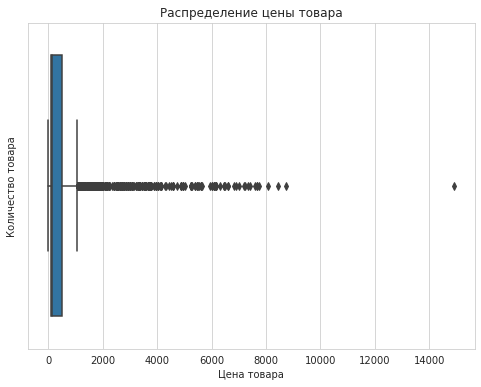

In [13]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.boxplot(data=data_new, x='price')
plt.title('Распределение цены товара')
plt.xlabel('Цена товара')
plt.ylabel('Количество товара')
plt.show()

In [14]:
np.percentile(data_new['price'], [95, 99])

array([2174.  , 4951.24])

Значит, 95% товара стоят меньше 4951 руб. Посмотрим на эти товары и на их количество.

In [15]:
display((data_new[data_new['price'] > np.percentile(data_new['price'], 99)]).shape)
display(data_new[data_new['price'] > np.percentile(data_new['price'], 99)])

(49, 10)

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
98,2018-10-04 17:00:00,d1a13243-9111-454f-848c-dcce0958528c,68529,сумка-тележка хозяйственная andersen scala sho...,1,5024.0,3,Четверг,Осень,False
596,2018-11-02 17:00:00,305c9634-ec53-46be-af05-48ee8bd790a5,68836,сумка-тележка хозяйственная andersen scala sho...,1,5249.0,4,Пятница,Осень,False
634,2018-11-05 02:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68856,сумка-тележка хозяйственная rolser imx005 mare...,1,6007.0,0,Понедельник,Осень,False
654,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,сумка-тележка хозяйственная rolser mou041 malv...,1,7597.0,0,Понедельник,Осень,False
655,2018-11-05 22:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68871,сумка-тележка хозяйственная rolser imx005 mare...,1,6007.0,0,Понедельник,Осень,False
768,2018-11-11 18:00:00,06e2fc7e-6183-4419-ada4-3b976baeed92,68952,коврик для ванной комнаты gobi полиэстер 120х7...,1,5474.0,6,Воскресенье,Осень,False
1116,2018-12-06 08:00:00,fa471f6f-1442-490c-acc6-a47b0822098c,69226,сумка-тележка хозяйственная andersen scala sho...,1,5249.0,3,Четверг,Зима,False
1121,2018-12-06 17:00:00,82b56a76-0dc9-4dae-aa76-863a9a80f082,69236,покрывало жаккард karna стеганое kalven 260x26...,1,6134.0,3,Четверг,Зима,False
1180,2018-12-12 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69320,сумка-тележка хозяйственная andersen treppenst...,1,5662.0,2,Среда,Зима,False
1241,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,гладильная доска leifheit airboard compact m p...,1,7424.0,0,Понедельник,Зима,False


Получилось всег 49 товаров стоят дороже, чем 95% всех товаров. Если посмотреть на них, то большинство из них - это сумка-тележка. Получается, что удалив выбросы из выборки, то пропадет полностью или частично товарная позиция. Поэтому пока оставим ее для категоризации.

Посмотрим на распределение по количеству товара в заказе.

In [16]:
data_new['quantity'].describe()

count    4873.000000
mean        2.837472
std        17.606813
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

Довольно большое стандартное отклонение и оно сильно отличается от среднего значения, значит, есть выбросы. Построим боксплот и найдем 95 и 99 перцентили.

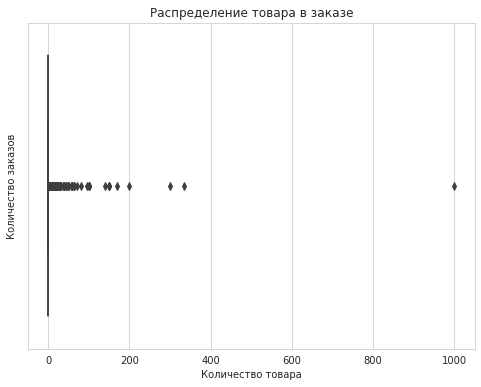

array([ 8., 30.])

In [17]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.boxplot(data=data_new, x='quantity')
plt.title('Распределение товара в заказе')
plt.xlabel('Количество товара')
plt.ylabel('Количество заказов')
plt.show()

np.percentile(data_new['quantity'], [95, 99])

95% товаров покупают в количестве меньше 8 штук и 99% - меньше 30. Посмотрим на товары свыше 30 штук в чеке.

In [18]:
display((data_new[data_new['quantity'] > np.percentile(data_new['quantity'], 99)]).shape)
display(data_new[data_new['quantity'] > np.percentile(data_new['quantity'], 99)])

(41, 10)

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38.0,0,Понедельник,Осень,False
144,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,набор вешалок для костюма 45см 4шт цвет: кремо...,37,202.0,0,Понедельник,Осень,False
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"стяжка оконная с болтом ст-55 цинк, 1108354",64,19.0,1,Вторник,Осень,False
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,3,Четверг,Осень,False
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,3,Четверг,Осень,False
233,2018-10-12 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68623,"петля приварная гаражная d 14х90 мм с шаром, 1...",50,38.0,4,Пятница,Осень,False
278,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,щетка для посуды *мила* sv3182 1807009,50,27.0,2,Среда,Осень,False
279,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,"щетка-утюжок с ручкой миди, standart, york, g1126",50,44.0,2,Среда,Осень,False
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,3,Четверг,Осень,False
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,4,Пятница,Осень,False


Таких товаров всего 41. Большинство из них подходят для оптовой торговли: крючки, крепежи, вешалки, искусственные цветы и муляжи, семена и растения и т.д. Вызывает подозрение большое количество купленных вантузов (аж 1 000 штук). Скорее всего, это какая-то ошибка, поэтому посмотри на этот заказ и удалим.

In [19]:
data_new[data_new['order_id']==71743]

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,1,Вторник,Лето,False


In [20]:
data_new = data_new[data_new['order_id']!=71743]

Посмотрим на количество заказов на каждого пользователя.

In [21]:
customer_by_orders = data_new.groupby('customer_id', as_index=False).agg({'order_id': pd.Series.nunique})\
.sort_values(by='order_id', ascending=False)
customer_by_orders.head(10)

,customer_id,order_id
1915,c971fb21-d54c-4134-938f-16b62ee86d3b,126
741,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1100,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1747,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
698,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
2146,e0535076-6270-4df2-8621-cb06264a94fa,4
1819,bea7a833-2074-42db-bc49-4457abd3c930,4
1010,6b0c6cfb-7717-4c34-8535-bbc6e2b2c758,3
2208,e8204583-4d55-4724-ad3f-049c7db43bdd,3


Получается, что есть три пользователя с аномально большим количеством заказов. 126 заказов за год выглядят нереалистично. Посмотрим подробнее на покупателей с 35 и 17 заказами за год.

In [22]:
data_new[data_new['customer_id'] == '4d93d3f6-8b24-403b-a74b-f5173e40d7db']

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
12,2018-10-01 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68485,чехол eurogold clean basic хлопок для досок 12...,1,187.0,0,Понедельник,Осень,False
21,2018-10-02 10:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68491,сумка-тележка 2-х колесная gimi argo синяя,1,1049.0,1,Вторник,Осень,False
42,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 3-х рядная деревянная 450 мм (пло...,15,49.0,1,Вторник,Осень,False
43,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 4-х рядная деревянная 300 мм (фиг...,15,70.0,1,Вторник,Осень,False
46,2018-10-02 14:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"вилка столовая ripple сталь 3 мм, 3 шт, attrib...",1,187.0,1,Вторник,Осень,False
47,2018-10-02 14:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"ложка столовая ripple сталь 3 мм, 3 шт, attrib...",1,202.0,1,Вторник,Осень,False
48,2018-10-02 14:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"ложка чайная ripple сталь 2,5 мм, 3 шт, attrib...",1,142.0,1,Вторник,Осень,False
49,2018-10-02 14:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"нож столовый ripple 80 г 2 шт, attribute, acr042",1,172.0,1,Вторник,Осень,False
50,2018-10-02 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68506,герань домашняя (пеларгония зональная) цветуща...,11,142.0,1,Вторник,Осень,False
70,2018-10-03 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68516,сушилка для белья потолочно-настенная gimi lif...,1,1649.0,2,Среда,Осень,False


Несмотря на большое количество заказов, в целом заказы довольно обычные. Единственное, что может насторожить, что все покупки были сделаны в течение 1 месяца. Возможно, покупатель делает ремонт.

Теперь посмотрим на покупки клиенты с 17 заказами за год.

In [23]:
data_new[data_new['customer_id'] == '73d1cd35-5e5f-4629-8cf2-3fda829d4e58']

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
6500,2019-10-02 15:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72836,чайник электрический василиса т31-2000 нержаве...,1,704.0,2,Среда,Осень,False
6533,2019-10-07 09:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72881,хризантема сиреневая d-18 см,1,187.0,0,Понедельник,Осень,False
6534,2019-10-07 10:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72883,"кипятильник электрический 2.5 квт, 1601143",1,224.0,0,Понедельник,Осень,False
6537,2019-10-07 16:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72889,чайник электрический василиса т28-1800 нержаве...,1,749.0,0,Понедельник,Осень,False
6563,2019-10-10 10:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72913,стремянка colombo factotum 4 ступени стальная ...,1,2849.0,3,Четверг,Осень,False
6610,2019-10-15 09:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72967,тележка багажная delta dt-22 синий грузоподъем...,1,674.0,1,Вторник,Осень,False
6625,2019-10-16 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72983,сумка-тележка хозяйственная gimi ideal синяя,1,1649.0,2,Среда,Осень,False
6626,2019-10-16 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72986,сумка-тележка хозяйственная rolser mnb012 azul...,1,6600.0,2,Среда,Осень,False
6631,2019-10-16 16:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72993,"таз пластмассовый 30,0 л овальный пц2913, 1404051",1,404.0,2,Среда,Осень,False
6632,2019-10-16 17:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72996,контейнер для мусора flip bin curver 25 л граф...,1,824.0,2,Среда,Осень,False


У этого покупателя тоже покупки довольно обычные. Немного странно, что он покупает не один раз сумки-тележки и сушилки для белья. Поскольку у нас нет данных о товарах, которые были возращены, то, есть вероятность, что купленные товары не подошли, и покупатель просто вернул товар. Также этот покупатель совершал покупки в течение месяца.

В целом, заказы этих двух покупателей довольно обычны. Так что избавимся только от покупателя со 126 заказами.

In [24]:
data_new = data_new[(data_new['customer_id'] != 'c971fb21-d54c-4134-938f-16b62ee86d3b')]
data_new.shape

(4729, 10)

Теперь посмотрим на столбец с датой и найдем период, за который предоставлены данные.

In [25]:
print('Дата первой транзакции ', data['date'].min())
print('Дата последней транзакции ', data['date'].max())

Дата первой транзакции  2018-10-01 00:00:00
Дата последней транзакции  2019-10-31 16:00:00


В таблице содержатся данные с 00 часов 1 октября 2018 года по 16 часов 31 октября 2019 года.

Также в процессе просмотра и вывода случаных строк с помощью метода `sample()` было замечено, что в таблице есть название товара `tepмокружка`, в котором первая буква написана латиницей. Изменим написания слова. Также заменим букву ё на е.

In [26]:
data_new['product'] = data_new['product'].str.replace('tepмокружка', 'термокружка')
data_new['product'] = data_new['product'].str.replace('ё', 'е')

Проверим, есть ли покупатели с одинаковыми заказами.

In [27]:
orders_grouped = data_new.groupby('order_id').agg({'customer_id': 'nunique'})
users_with_same_orders = orders_grouped[orders_grouped['customer_id'] >= 2].reset_index()
display(users_with_same_orders.shape)
display(users_with_same_orders.sort_values(by='customer_id', ascending=False))

(29, 2)

,order_id,customer_id
27,72845,4
6,69485,3
19,71480,3
0,14872,2
15,70946,2
26,72790,2
25,72778,2
24,72188,2
23,71663,2
22,71648,2


Получается, что у 29 заказов повторяются у нескольких покупателей. Посмотрим на несколько таких заказов.

In [28]:
data_new[(data_new['order_id'] == 72845)|(data_new['order_id'] == 69485)|(data_new['order_id'] == 71480)]

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germ...,1,1087.0,3,Четверг,Зима,False
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,набор столовых приборов 24 предмета farandole ...,1,1274.0,4,Пятница,Зима,False
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,набор столовых приборов 24 предмета farandole ...,1,1274.0,2,Среда,Зима,False
3963,2019-05-21 02:00:00,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74.0,1,Вторник,Весна,False
4025,2019-05-24 22:00:00,d8080f8f-3685-433b-b416-beb0a8f06606,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74.0,4,Пятница,Весна,False
4026,2019-05-25 02:00:00,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74.0,5,Суббота,Весна,False
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0,3,Четверг,Осень,False
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0,3,Четверг,Осень,False
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0,4,Пятница,Осень,False
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0,0,Понедельник,Осень,False


Довольно странные заказы. Они практически повторяются у разных покупателей. Лучше удалить их и передать коллегам-разработчикам, чтобы они посмотрели, с чем связана такая аномалия. Возможно, есть какая-то ошибка при присвоении индентификатора заказа или покупателя. Сейчас удалим их из данных.

In [29]:
data_new = data_new.loc[~data_new['order_id'].isin(users_with_same_orders['order_id'])]
data_new.shape

(4663, 10)

**Вывод**

Был проведен исследовательский анализ данных в результате были сделаны следующие выводы и преобразования в таблице:

* изменены данные в столбце с датой транзакции и приведены к нижнему регистру записи в столбце с названием продукта;
* было найдено, что 27,7% строк в датасете дублируют друг друга. При их анализе принято решение удалить и передать баг-репорт коллегам для установления точной причины их возникновения;
* часть товаров в таблице стоят значительно дороже. Их было решено не удалять, чтобы не потерять категорию товаров;
* был удален пользователь с аномально большим количеством заказов;
* заказ с большим количеством товара был также убран;
* данные о транзакциях собирались с 00 часов 1 октября 2018 года по 16 часов 31 октября 2019 года;
* заменены буквы в названии товаров для дальнейшей категоризации;
* были удалены заказы, у которых было больше одного пользователя.

## Анализ торгового ассортимента

### Категоризация товаров

Перейдем к анализу товарного ассортимента. Для начала попробуем посмотреть, сколько раз встречаются названия товаров. Для этого найдем уникальные значения в столбце `product`.

In [30]:
data_new['product'].value_counts()

пеларгония розебудная red pandora укорененный черенок                                                                           62
пеларгония розебудная prins nikolai укорененный черенок                                                                         53
пеларгония зональная диам. 12 см сиреневый полумахровый                                                                         52
сумка-тележка 2-х колесная gimi argo синяя                                                                                      45
пеларгония розебудная mary укорененный черенок                                                                                  39
                                                                                                                                ..
коврик придверный влаговпитывающий hello, bonjour, ciao из переработанной резины и коврового покрытия 60х90 см, apache, 4658     1
петуния surprise purple sky фиолетовая с прожилками объем 0,5 л                    

Из 4663 строк удалось сгруппировать только в 2269. Значит в столбце с название продукта слишком много уникальных названий товара. Выделим первое слово в каждой строке и создадим столбец `first_word`. Затем проведен леммитизацию.

In [31]:
rgx = re.compile("(\w[\w']*\w|\w)")
data_new['first_word'] = data_new['product'].map(lambda x: rgx.search(x).group())
m = Mystem()
def lemmas_purpose(purpose):
    lemmas = m.lemmatize(purpose)
    return ''.join(lemmas[0])
data_new['lemmas_first_word']=data_new['first_word'].apply(lemmas_purpose)
data_new.head()

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate,first_word,lemmas_first_word
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,Понедельник,Осень,False,комнатное,комнатный
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,0,Понедельник,Осень,False,комнатное,комнатный
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,Понедельник,Осень,False,радермахера,радермахер
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,Понедельник,Осень,False,хризолидокарпус,хризолидокарпус
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,Понедельник,Осень,False,циперус,циперус


Теперь сгруппируем данные по столбцы с леммами.

In [32]:
data_grouped_by_first_word = data_new.groupby('lemmas_first_word', as_index=False).agg({'quantity':'count'})\
.sort_values(by='quantity', ascending=False)
data_grouped_by_first_word

,lemmas_first_word,quantity
238,пеларгония,699
281,рассада,478
332,сушилка,246
331,сумка,229
196,муляж,166
...,...,...
1,агератум,1
212,незабудка,1
213,нетканый,1
217,ножеточка,1


Уже намного меньше строк, хотя все еще довольно много, чтобы можно было провести кластеризацию на основании этой группировки.

Чтобы провести категоризацию товаров сохраним таблицу `data_grouped_by_first_word` на компьютер, затем в ручную в google таблице объединим слова по схожим группам и проставим категории.

Ссылка на google таблица - [Категоризация товаров](https://docs.google.com/spreadsheets/d/1yY408tK02H2GafG1KZ9zz4__rU3AlPuN3AMD7xd3uR0/edit?usp=sharing).

Ниже будем выводить строки из датасета, чтобы посмотреть полные названия товаров.

*Примечание: приведен фильтр только по одному слову. В процессе кластеризации заменяла в строке слово, если возникали сложности с определением категории.*

In [33]:
data_grouped_by_first_word.to_csv('groups.csv', index=False)

In [34]:
data_new[data_new['lemmas_first_word']=='однолетний']

,date,customer_id,order_id,product,quantity,price,weekday_number,weekday,season,duplicate,first_word,lemmas_first_word
2271,2019-03-10 17:00:00,d6e6f56f-3f6e-4b35-82ae-31ff4a290bc1,14569,однолетнее растение петуния махровая в кассете...,2,90.0,6,Воскресенье,Весна,False,однолетнее,однолетний
2272,2019-03-10 17:00:00,d6e6f56f-3f6e-4b35-82ae-31ff4a290bc1,14569,однолетнее растение петуния простая в кассете ...,1,82.0,6,Воскресенье,Весна,False,однолетнее,однолетний
2273,2019-03-10 17:00:00,d6e6f56f-3f6e-4b35-82ae-31ff4a290bc1,14569,однолетнее растение табак душистый в кассете п...,1,82.0,6,Воскресенье,Весна,False,однолетнее,однолетний
2752,2019-04-09 11:00:00,f83934ea-15ab-474d-8cbe-16ee6288d33a,14629,однолетнее растение петуния простая в кассете ...,2,82.0,1,Вторник,Весна,False,однолетнее,однолетний
2888,2019-04-16 14:00:00,42f210be-2e9c-43fa-b65a-e7891d90b98b,14651,однолетнее растение петуния махровая в кассете...,1,82.0,1,Вторник,Весна,False,однолетнее,однолетний
...,...,...,...,...,...,...,...,...,...,...,...,...
5424,2019-06-17 17:00:00,bea7a833-2074-42db-bc49-4457abd3c930,14867,однолетнее растение львиный зев в кассете по 4...,1,82.0,0,Понедельник,Лето,False,однолетнее,однолетний
5900,2019-07-20 12:00:00,1046d601-0ec2-4038-a1d9-ede848cf5509,14903,однолетнее растение бегония вечноцветущая в ка...,8,82.0,5,Суббота,Лето,False,однолетнее,однолетний
5901,2019-07-20 12:00:00,1046d601-0ec2-4038-a1d9-ede848cf5509,14903,"однолетнее растение вербена в кассете по 4 шт,...",10,82.0,5,Суббота,Лето,False,однолетнее,однолетний
5902,2019-07-20 12:00:00,1046d601-0ec2-4038-a1d9-ede848cf5509,14903,"однолетнее растение лобелия в кассете по 4 шт,...",2,82.0,5,Суббота,Лето,False,однолетнее,однолетний


Теперь загрузим таблицу с категориями и объединим ее с таблицей `data_new`.

In [35]:
# загружаем google таблицу и сохраняем в переменной category
spreadsheet_id = '1yY408tK02H2GafG1KZ9zz4__rU3AlPuN3AMD7xd3uR0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
category = pd.read_csv(BytesIO(r.content))

# объединяем таблицу data_new и category
data_category =  data_new.merge(category, how='left', on='lemmas_first_word')

# создаем финальную таблицу с нужными столбцами и переименовываем столбец
data_final = data_category[['date', 'customer_id', 'order_id', 'product', 'quantity_x', 'price', 'category', 'weekday', 'season', 'weekday_number']]
data_final = data_final.rename({'quantity_x': 'quantity'}, axis=1)

# выводим таблицу data_final
data_final.head()

,date,customer_id,order_id,product,quantity,price,category,weekday,season,weekday_number
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,"рассада, семена, растения",Понедельник,Осень,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,"рассада, семена, растения",Понедельник,Осень,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,"рассада, семена, растения",Понедельник,Осень,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,"рассада, семена, растения",Понедельник,Осень,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,"рассада, семена, растения",Понедельник,Осень,0


### Анализ категорий товаров

Сгруппируем данные по категориям и посчитаем количество товаров, общую и среднюю цену.

In [36]:
data_final['amount'] = data_final['quantity'] * data_final['price']
data_by_category = data_final.groupby('category', as_index=False).agg({'product':pd.Series.nunique, 
                                                                       'quantity': 'count',
                                                                       'price': 'mean',
                                                                       'amount': 'sum'})
data_by_category.columns = ['category', 'unique_product', 'amount_product', 'mean_price', 'total_price']
data_by_category['mean_price'].round(2)
display(data_by_category.sort_values(by='total_price', ascending=False))
print('Средняя стоимость по всем категориям: ', ((data_by_category['total_price']).sum()
                                                 /data_by_category['amount_product'].sum()).round(2))

,category,unique_product,amount_product,mean_price,total_price
0,интерьер,413,674,558.780415,684520.0
4,сумки и тележки,102,322,1922.754658,657042.0
6,уход за одеждой и обувью,243,456,1119.109649,623122.0
2,"рассада, семена, растения",920,2459,149.245222,513845.0
7,хранение и посуда,330,428,493.579439,362915.0
5,уборка,121,160,553.000000,150473.0
3,ремонт и инструменты,76,96,1254.416667,150412.0
1,разное,64,68,701.176471,117778.0


Средняя стоимость по всем категориям:  699.14


Получается, что больше всего прибыли приносит категория "интерьер", которая включает в себя коврики, чехлы, искусственные фрукты, овощи и растения, шторы и карнизы, а также другие товары, которые помогают сделать дом уютнее и удобнее. При этом, здесь не самая высокая средняя цена, зато второе место по количеству проданных товаров. Следующей категорией по прибыльности за рассматриваемый период является категория "сумки и тележки". Это категория с самой большой средней ценой.

Категория "уход за одеждой и обувью": в нее попали гладильные доски и дополнения к ним (подкладки, подрукавник), сушилки, вешалки, предметы для хранения одежды и обуви, идет на третьем месте по прибыльности. У этой категории третья по весу средняя цена, которая в 1,7 раз меньше категории "сумки и тележки". Это категория идет также на третьем месте по количеству проданного товара.

Самая многочисленная категория по количеству проданного товара - "рассада, семена, растения". Она наиболее разнообразно представлена по уникальности товаров, но у нее самая маленькая средняя цена. Действительно, товары этой категории, как правило, стоят не дорого и покупатели берут намного больше семян и рассад, чтобы посадить их на своих участках или разводить дома.

В категории "хранение и посуда" средний чек равен 493,58 руб., что ниже среднего чека по всем категориям. Эта категория состоит из посуды, столовых приборов, кухонных принадлежностей и разных емкостей для хранения.

Категория "уборка" малочислена по числу проданных товаров, хотя средний чек практически равен самой прибыльной категории - "интерьер".

Категория "ремонт и инструменты" приносит гораздо меньше денег, чем категория "сумки и тележки", но у нее высокий размер среднего чека - 1254,42 руб. Это связано, что в этой категории находятся стремянки, которые стоят дорого. Но их редко покупают. Здесь аналогичная ситуация как с гладильными досками: покупатели редко покупают больше одного товара.

В категории "разное" меньше всего продано товара, зато у нее неплохой средний чек. Прежде всего, за счет различных наборов (инструментов, посуды и приборов, моющих средств, постельного белья).

Посмотрим, есть ли заказы с несколькими категория в чеке. Для этого сгруппируем данные по `order_id`.

In [37]:
data_by_orders = data_final.groupby(['order_id'], as_index=False).agg({'price':'sum', 'category':pd.Series.nunique})
data_by_orders.sort_values(by='category', ascending=False)

,order_id,price,category
482,68760,17060.0,5
648,69090,2109.0,4
336,68521,567.0,4
578,68941,1780.0,4
434,68682,1615.0,4
...,...,...,...
903,69655,2549.0,1
904,69658,899.0,1
905,69661,1612.0,1
906,69663,149.0,1


Такие заказы есть, отберем только те покупки, в которых больше одной категории товара. Затем выведем у каждого заказа его категории и посчитаем, сколько раз встречаются сочетания разных категорий.

In [38]:
# отбираем заказы с более чем одной категорией
filtred = data_by_orders[data_by_orders['category'] > 1]
different_categories = data_final.loc[data_final['order_id'].isin(filtred['order_id'])]

# создаем таблицу с номерами заказов и категориями
different_categories_pivot = different_categories.pivot_table(index=['order_id', 
                                                                   'category'], values = 'price', aggfunc='count').reset_index()

# создаем функцию, которая объединит все категории в рамках 1 заказа в одну строку
def unite_areas(series):
    return reduce(lambda x, y: x + ', ' + y, series)

pd.set_option('display.max_colwidth', -1)
orders_by_category = different_categories_pivot.groupby('order_id', as_index=False).agg({'category': unite_areas})

# считаем, сколько раз встречатся сочетания категорий
orders_by_category['category'].value_counts().to_dict()

{'интерьер, уход за одеждой и обувью': 7,
 'рассада, семена, растения, уход за одеждой и обувью': 3,
 'интерьер, разное, хранение и посуда': 3,
 'уборка, хранение и посуда': 2,
 'интерьер, уборка': 2,
 'интерьер, рассада, семена, растения': 2,
 'уход за одеждой и обувью, хранение и посуда': 2,
 'ремонт и инструменты, хранение и посуда': 2,
 'интерьер, сумки и тележки, хранение и посуда': 1,
 'уборка, уход за одеждой и обувью, хранение и посуда': 1,
 'интерьер, разное': 1,
 'рассада, семена, растения, хранение и посуда': 1,
 'ремонт и инструменты, уборка': 1,
 'интерьер, уборка, уход за одеждой и обувью': 1,
 'разное, ремонт и инструменты, хранение и посуда': 1,
 'рассада, семена, растения, сумки и тележки': 1,
 'интерьер, сумки и тележки': 1,
 'ремонт и инструменты, сумки и тележки': 1,
 'интерьер, разное, уборка, уход за одеждой и обувью, хранение и посуда': 1,
 'интерьер, разное, рассада, семена, растения, уборка': 1,
 'рассада, семена, растения, уборка': 1,
 'разное, ремонт и инстру

Проанализировав все сочетания двух категорий в рамках одного заказа, можно заметить следующие закономерности:
* чаще всего встречается сочетание категорий "уход за одеждой и обувью" и "интерьер";
* затем идут сочетания "интерьер - уборка" и "интерьер - хранение и посуда", "интерьер - разное", "хранение и посуда - уборка" и "хранение и посуда - разное";
* категорию "уход за одеждой и обувью" часто покупают вместе с "уборкой", "рассадой, семенами, растениями" и "хранением и посудой".

Получается, что товары для дома (интерьер, уход за одеждой и обувью, хранение и посуда, уборка) чаще покупают вместе.

С наиболее массовой категорией по количеству покупок "рассада, семена, растения" в основном покупают с категориями "уход за одеждой и обувью", "интерьер", "хранение и посуда", "уборка". Но чаще семена и рассаду покапают, как самостоятельную категорию.

Две категории "сумки и тележки" и "ремонт и инструменты" крайне редко покупают вместе с другой категорией. Похоже сказывается высокая стоимость товаров в данных категориях. Возможно, что покупатели целенаправленно покупают только товары из этих категорий: например, только стремянку или тележку.

Посмотрим на категории товаров, которые в чеке чаще всего появляются по одному.

In [39]:
# отбираем заказы только с одной категорией
filtred_category = data_by_orders[data_by_orders['category'] == 1]
single_category = data_final.loc[data_final['order_id'].isin(filtred_category['order_id'])]

# группируем данные
single_category_grouped = single_category.groupby('category', as_index=False).agg({'order_id':'count'})\
.sort_values(by='order_id', ascending=False)

# добавляем столбец с общим количеством категорий
cagetories_merge = single_category_grouped.merge(data_by_category[['category', 'amount_product']], how='left', on='category')
cagetories_merge = cagetories_merge.rename({'order_id': 'amount_single_category'}, axis=1)

# считаем, какой процент от общего числа категории занимают заказы с 1 категорией
cagetories_merge['ratio'] = cagetories_merge['amount_single_category']/cagetories_merge['amount_product']
cagetories_merge

,category,amount_single_category,amount_product,ratio
0,"рассада, семена, растения",2419,2459,0.983733
1,интерьер,624,674,0.925816
2,уход за одеждой и обувью,426,456,0.934211
3,хранение и посуда,384,428,0.897196
4,сумки и тележки,318,322,0.987578
5,уборка,131,160,0.818750
6,ремонт и инструменты,86,96,0.895833
7,разное,51,68,0.750000


Вероятно, что чем больше чеков от общего числа имеют одну категорию, тем выше "самостоятельность" категории, ради которых покупатели заходят в магазин. Т.е. данную категорию чаще покупают как основную. Тогда, если предположение верное, то основными категориями можно назвать "рассада, семена, растения", "сумки и тележки". Чуть менее самостоятельные: "интерьер" и "уход за одеждой и обувью". А категории "разное", "уборка", "ремонт и инструменты" и "хранение и посуда" чаще всего покупают с чем-то, т.е. это менее самостоятельные категории.

Если есть основные категории, то, вероятно, они приносят больше денег и их средний чек выше, чем у дополнительных.

### Анализ категорий по месяцам

Посмотри, как распределяются покупки по разным категориям по месяцам. Для этого выделим столбец с месяцем, создадим свободную таблицу и построим тепловую карту.

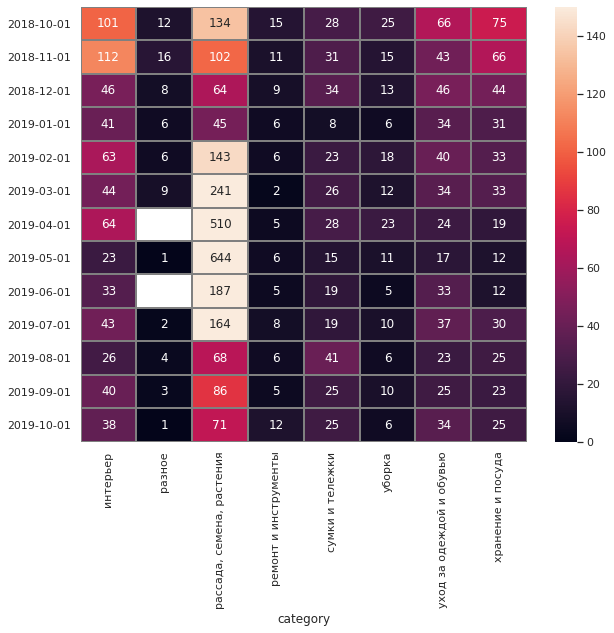

In [40]:
# добавляем толбец с месяцем
data_final['month'] = data_final['date'].astype('datetime64[M]')

# создаем сводную таблицу по месяцам и категориям
category_by_month = data_final.pivot_table(index='month',columns='category',values='order_id', aggfunc='count')

# рисуем тепловую карту
category_by_month.index = category_by_month.index.strftime('%Y-%m-%d')
sns.set(style='white')
plt.figure(figsize=(10, 8))
sns.heatmap(category_by_month, annot=True, fmt = 'g', linewidths=1, linecolor='gray', vmin=0, vmax=150)
plt.show()

Если рассматривать по продажу категорий по месяцам, то получается следующее:

* продажи в категории "рассада, семена, растения" возрастают начиная с февраля, как раз, когда начинается подготовка рассады и семян для будущего сада/огорода, достигают максимального значения в мае, затем начинают резко снижаться;
* товары из категории интерьер чаще покупают в октябре и ноябре, похоже, что покупатели задумываются об устройстве своего дома, когда на улице становится холоднее. Также продажи немного возрастаю в феврале и апреле;
* на "сумки и тележки" спрос возрастает в августе, ноябре и декабре;
* категория "уборка" в целом довольно стабильна. Но ее чаще покупают в холодное время года, за исключением января (периода праздников). Возможно, это связано с большим временем нахождения людей дома;
* спрос на категории "уход за одеждой и обувью" и "хранение и посуда" в чем-то похож: наибольшие значения в первые месяцы исследуемого периода, затем спрос постепенно начинает снижаться, немного поднимаясь к концу периода;
* спрос на "разное" падает в течение всего исследуемого периода.

### Анализ категорий по дням недели

Рассмотрим количество проданного товара в каждой категории в разрезе дней недели.

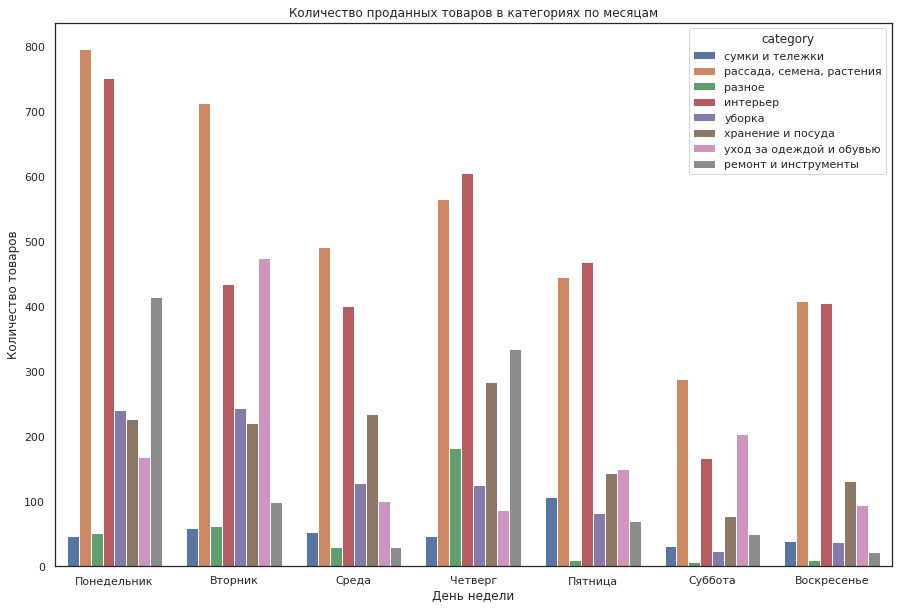

In [41]:
category_by_weekday = data_final.groupby(['weekday', 'weekday_number', 'category'])['quantity'].sum().reset_index().sort_values(by='weekday_number')

plt.figure(figsize = (15,10))
sns.barplot(x = 'weekday', y = 'quantity', data = category_by_weekday, hue = 'category', dodge=True)
plt.xlabel('День недели')
plt.title('Количество проданных товаров в категориях по месяцам')
plt.ylabel('Количество товаров')
plt.show()

Больше всего товара всех категорий продается в понедельник, вторник и четверг. Меньше всего - в субботу и воскресенье.

Категории "интерьер" и "рассада, семена, растения" повторяют общую динамику по количеству продаж. Это связано с тем, что это две самые продаваемые категории, поэтому именно они сильно влияют на общие продажи.

Категория "сумки и тележки" практически во все дни продается на одном уровне, за исключением пятницы - количество проданных товаров в 1,5-3 раза выше, чем в остальные дни.

В категории "разное" пик продаж приходится на четверг, причем с большим отрывом. С пятницы по воскресенье товары этой категории практически не покупают.

Спрос на товары для уборки падает в течение недели. Самые высокие продажи во вторник и понедельник, затем они начинают резко уменьшаться и к концу недели их покупает в 6-7 раз меньше.

"Хранение и посуда" лучше всего продается с понедельника по четверг. В пятницу и выходные дни продажи уменьшаются в 2-3 раза.

Пик продаж в категории "уход за одеждой и обувью" с большим отрывом приходится на вторник. Затем идут суббота, понедельник и пятница. Меньше всего продаж в воскресенье и четверг.

Товары для ремонта и инструменты чаще покупают в понедельник и четверг. В остальные дни количество проданного товара не превышает 10 единиц.

### Анализ категорий по сезонам

Теперь посмотрим на сезонность товара.

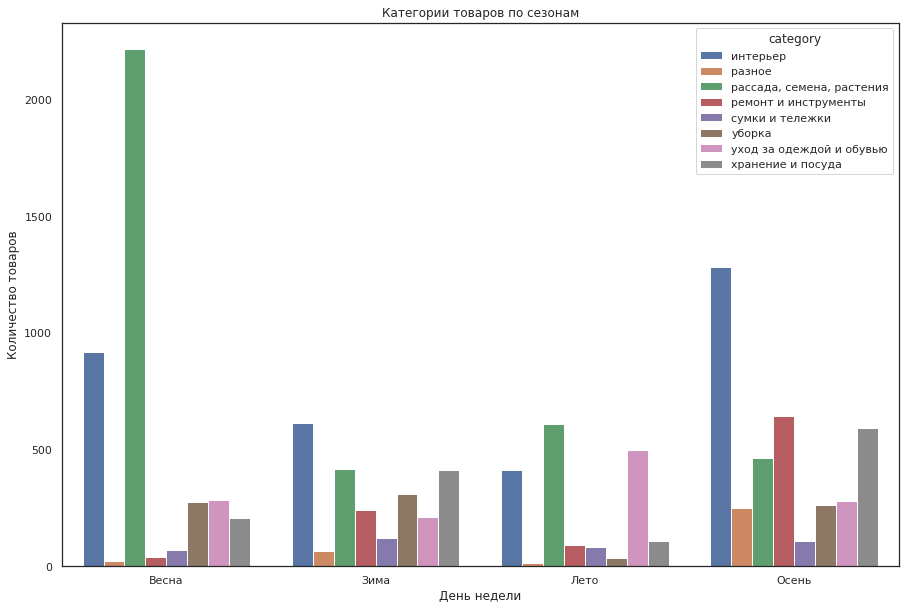

In [42]:
category_by_season = data_final.groupby(['season', 'category'])['quantity'].sum().reset_index()
plt.figure(figsize = (15,10))
sns.barplot(x = 'season', y = 'quantity', data = category_by_season, hue = 'category')
plt.xlabel('День недели')
plt.ylabel('Количество товаров')
plt.title('Категории товаров по сезонам')
plt.show()

Весной и осенью продажи намного выше, чем зимой и летом.

Весной наиболее чаще покупают:

* рассаду, семена и растения, т.к. люди готовятся к дачному и огородному сезону;
* интерьер - покупатели начинают активно обустраивать свой дом, обновлять интерьер;
* уход за одеждой и обувью - значительно меньше продажи, чем в двух предыдущих категориях.

Осенью больше популярностью пользуются категории:

* интерьер - самая продаваемая категория, люди начинают готовиться к холодному времени года и обустраивают свои жилища, т.к. будут дольше проводить время дома;
* ремонт и инструменты - вероятно, покупатели приводят в порядок дома, ремонтируют перед началом холодов;
* хранение и посуда - возможно, покупатели восполняют "утраченную" летом посуду, готовят запасы (ягоды, грибы, овощи и т.д.) на зиму из собранного урожая.

Для зимы характерны следующие товары:

* интерьер - продолжается обустройство дома, начатое осенью;
* рассада, семена и растения - скорее всего, сюда попадают комнатные растения, которые люди выращивают у себя дома;
* хранение и посуда - можно отнести к облагораживанию дома.

Летом заметно выделяются три категории товаров:

* рассада, семена и растения - покупатели продолжают докупать, поскольку в этот период времени по-прежнему можно высаживать растения и семена;
* уход за одеждой и обувью - самые большие продажи в этой категории среди всех сезонов. Вероятно, что люди обновляют или докупают недостающие товары;
* интерьер - продолжается обустройство дач и домов.

**Вывод**

1. В рамках анализа товаров было определено восемь категорий:

    * сумки и тележки;
    * уход за одеждой и обувью: гладильные доски и дополнения к ним (подкладки, подрукавник), сушилки, вешалки, предметы для хранения одежды и обуви;
    * интерьер: коврики, чехлы, искусственные фрукты, овощи и растения, шторы и карнизы, другие товары для создания уюта и удобства дома;
    * рассада, семена, растения;
    * хранение и посуда: посуда, столовые приборы, кухонные принадлежности и разные емкости для хранения;
    * ремонт и инструменты: стремянки, детали и инструменты для ремонта;
    * уборка: швабры, щетки, моющие и чистящие средства;
    * разное: остальные товары, в основном, подарочные наборы разных товаров.


2. Если смотреть по прибыли, то больше всего приносит категория "интерьер", т.к. товары здесь дорогие и их могут покупать в большом количестве. Затем идут категории "сумки и тележки" и "уход за одеждой и обувью". Самой продаваемой по количеству товара является категория "рассада, семена, растения", также в ней наиболее разнообразные товары. У нее самый маленький средний чек и 4 место по принесенным деньгам. Меньше всего покупают товары категорий "ремонт и инструменты" и "разное", при этом у них довольно высокий средний чек.


3. Посмотрели на категории товаров, которые чаще других оказываются вместе в одном чеке. Чаще всего встречаются "уход за одеждой и обувью" и "интерьер", затем "интерьер - уборка" и "интерьер - хранение и посуда", "интерьер - разное", "хранение и посуда - уборка" и "хранение и посуда - разное". Категории "сумки и тележки" и "ремонт и инструменты" крайне редко покупают вместе с другой категорией.


4. Товары категорий "рассада, семена, растения", "сумки и тележки", "интерьер" и "уход за одеждой и обувью" можно назвать основными. А категории "разное", "уборка", "ремонт и инструменты" и "хранение и посуда" - дополнительными.


5. За исключением категорий "рассада, семена, растения" и "разное" все остальные имеют схожую динамику в течение года: самые высокие значения по количеству продаваемого товара в первые 2-3 месяца, затем небольшой спад на 1-2 месяца и снова подъем в феврале-апреле, который заканчивается снижением с мая по сентябрь. Возможны незначительные подъемы в летние месяцы. В свою очередь категория "рассада, семена, растения" резко возрастает с февраля по май, затем также резко падает.


6. Практически все категории товаров значительно хуже продаются по выходным дням. Самыми "продаваемыми" днями являются понедельник, вторник и четверг. Стоит обращать внимание на популярность категорий в определенные дни и в зависимости с этим выстраивать рекламные акции/кампании.


7. Активнее всего товары продаются весной и осенью. Весной и летом чаще покупают растения и семена, а осенью и зимой - товары из категории "интерьер".

## Кластеризация покупателей

Чтобы выделить кластеры, построим дендрограмму и посчитаем метрику силуэта (silhouette score). Она покажет, насколько объект своего кластера похож на свой кластер больше, чем на чужой.

Сначала создадим таблицу `segmentation`, в которой будут следующие данные, сгруппированные для каждого пользователя:

* количество уникальных категорий;
* количество уникальных заказов;
* общая выручка;
* общее количество купленных товаров;
* средняя стоимость купленных товаров;
* средний чек.

In [43]:
segmentation = data_final.groupby(['customer_id']).agg(
    {'category':'nunique', 'order_id':'nunique','amount':'sum','quantity':'sum','price':'mean'}).reset_index()
segmentation['average_check'] = segmentation['amount'] / segmentation['order_id']
segmentation.columns = ['customer_id', 'category_per_user', 'order_per_user', 'total_revenue', 
                        'total_quantity', 'mean_price', 'average_check']
segmentation

,customer_id,category_per_user,order_per_user,total_revenue,total_quantity,mean_price,average_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,555.0,4,138.75,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.0,1,442.00,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1,914.0,2,457.00,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.0,1,1649.00,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1,2324.0,2,1162.00,2324.0
...,...,...,...,...,...,...,...
2387,ff601403-b094-4b86-9ac6-264d725b9277,1,1,1649.0,1,1649.00,1649.0
2388,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,1,397.0,1,397.00,397.0
2389,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,1,389.0,1,389.00,389.0
2390,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,1,974.0,1,974.00,974.0


Теперь перейдем к обучению модели и проведению кластеризация. Прежде уберем столбец с уникальным номером клиента.

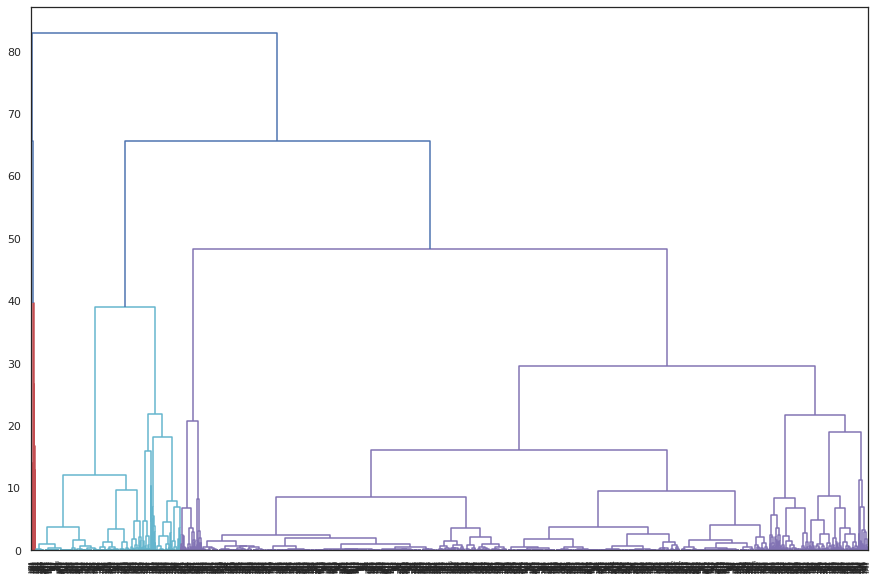

In [44]:
# стандартизируем данные перед работой с алгоритмами
X = segmentation.drop('customer_id', axis = 1)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# находим расстояние
linked = linkage(X_sc, method = 'ward')

# рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На дендрограмме выделено цветом 3 кластера. Посчитаем `Silhouette_score` для количества кластеров от 2 до 9.

In [45]:
for i in range(2,10):
    # задаём модель k_means с числом кластеров i
    km = KMeans(n_clusters = i)
    # прогнозируем кластеры для наблюдений
    labels = km.fit_predict(X_sc)

    print('Количество кластеров', i)
    print('Silhouette_score: {:.5f}'.format(silhouette_score(X_sc, labels)))
    print('')

Количество кластеров 2
Silhouette_score: 0.92577

Количество кластеров 3
Silhouette_score: 0.64930

Количество кластеров 4
Silhouette_score: 0.64636

Количество кластеров 5
Silhouette_score: 0.67449

Количество кластеров 6
Silhouette_score: 0.56947

Количество кластеров 7
Silhouette_score: 0.57143

Количество кластеров 8
Silhouette_score: 0.58673

Количество кластеров 9
Silhouette_score: 0.59797



Ближе всего к 1 - разделение на два кластера, но если смотреть по дендрограмме, то получится, что один из кластеров будет незначительным по количеству клиентов в каждой группе. Далее по `Silhouette_score` ближе к 1 разбиение на 4 и 5 кластера. Проверив размерность кластеров, получилось что алгоритм выделяет слишком узкие сегменты покупателей. Поэтому оптимальным можно считать разделение на три кластера.
Выделим их и добавим кластеры к данным, затем сгруппируем и посмотрим на них.

In [46]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3, random_state = 0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# добавим кластеры к данным
segmentation['label'] = labels
grouped_segmentation = segmentation.groupby(['label']).mean().reset_index()

# добавим столбец с общим количеством покупателей в сегменте
grouped_segmentation['user_count'] = segmentation.groupby(['label']).agg({'customer_id' : 'count'})
grouped_segmentation

,label,category_per_user,order_per_user,total_revenue,total_quantity,mean_price,average_check,user_count
0,0,1.017021,1.055319,4599.595745,3.659574,3473.426596,4354.573759,235
1,1,1.034467,1.078714,858.730787,4.533302,484.047477,805.697473,2147
2,2,2.800000,6.400000,33550.700000,158.000000,635.514370,20172.004370,10


Судя по получившимся значениям, клиентов можно выделить оптовых, розничных клиентов и розница-премиум.

**Кластер 0** или розница-премиум: покупают немного товаров - не более 1 категории с 3-4 позициями, но с большой стоимостью - каждый клиент в среднем тратит за все время - 4 600 руб. Средний чек - 4 354,57 руб., а стоимость товара - около 3 473 руб.

Для увеличения продаж в этой категории стоит попробовать ввести программу скидок для повторных заказов, т.к. покупатели совершают только по 1 заказу. Делать рассылку с предложением на товары из высокой ценовой категории со скидкой для клиента. Предлагать сопутствующие товары из категорий с низкой ценой, как дополнения к дорогим товарам.

**Кластер 1** - это розничные клиенты или обычные покупатели. Самый многочисленный сегмент. Как правило, они покупают товары из одной категории и делают по одному заказу, состоящий из 4-5 позиций. Средний чек равен 806 руб., общая выручка - 858,73 руб. В среднем покупатели из первого кластера покупают товары стоимость около 484 руб. 

В качестве рекомендации по взаимодействию с этим сегментом можно предложить использовать программу лояльности при совершении более 1 заказа. Ввести дополнительные скидки и предложения (например, бесплатная доставка) при заказе больше определенной суммы или позиций в чеке. Предлагать похожие товары, которые клиент покупал ранее.

**Кластер 2** - это оптовые клиенты. В нем меньшего всего покупателей, зато они приносят больше всего прибыли. Клиенты этого кластера делают заказ в среднем 6 раз, покупают товары из 2-3 категорий, общая выручка с 1 покупателя выше в 7 раз, чем в кластере 0 и в 39 раз больше кластера 1. Количество товарных позиций в чеке также намного больше - 158. Средний чек - более 20 тыс. руб., при этом товары в среднем стоят 635,5 руб. ниже, чем у кластера 0 в 5,5 раз.

Чтобы удержать клиентов этого сегмента, можно предлагать систему бонусов и скидок, заключать партнерские соглашения, предлагать дополнительное обслуживание по доставке. Но стоит оценивать затраты на их удержание, т.к. несмотря на большой средний чек, приносят они в 4-5 раз меньше прибыли, чем два других сегмента.

**Вывод**

В рамках кластеризации было выделено три сегмента клиентов:

1. Розница-премиум: клиенты, которые покупают не часто, с 3-4 товарными позициями, как правило, из 1 категории, с большой стоимостью товаров. Стоит уделить внимание низкому возврату клиентов, предлагать привилегии при повторном заказе, делать персональные рассылки;
2. Розничные клиенты: покупатели из самого многочисленного сегмента с небольшим средним чеком, состоящим из 4-5 позиций товаров из 1 категории. Также стоит повышать процент повторных заказов, предлагать дополнительные скидки при заказе сверх суммы или количества товаров;
3. Оптовые клиенты: неоднократно возвращаются, покупают много товаров за раз, высокий средний чек. Стоит уделить внимание персональным предложениям, выгодным условиям сотрудничества.

## Проверка статистических гипотез

**Гипотеза 1**

Проверим гипотезу о том, что средний чек заказов, состоящих из нескольких категорий, и заказы только с одной категорией различаются.

* Нулевая гипотеза: средний чек заказов, состоящих из нескольких категорий, и заказов с одной категорией не отличается;
* Альтернативная гипотеза: средний чек заказов, состоящих из нескольких категорий, и заказов с одной категорией различается.

Для проверки гипотезы критический уровень статистической значимости принимается 0.05.

In [47]:
# группируем по заказам
different_categories_orders = different_categories.groupby('order_id', as_index=False).agg({'amount':'sum'})

# сохраняем только чеки
sample_different_categories = different_categories_orders['amount']

# группируем по заказам
single_category_orders = single_category.groupby('order_id', as_index=False).agg({'amount':'sum'})

# сохраняем только чеки
sample_single_category = single_category_orders['amount']

print('Статистическая значимость различия средних чеков (p-value): {0:.3f}'
      .format(stats.mannwhitneyu(sample_different_categories, sample_single_category, True, 'two-sided')[1]))
print('Относительный разница между средними чеками групп: {0:.3f}'.format((single_category_orders['amount'].mean()/
                                                                             different_categories_orders['amount'].mean())))

Статистическая значимость различия средних чеков (p-value): 0.000
Относительный разница между средними чеками групп: 0.389


`P-value` меньше 0.05, поэтому нулевую гипотезу отвергаем. Относительная разница между чеками составляет 38,9%. Получается, что нельзя утверждать, что средние чеки между заказами с несколькими категориями и заказами с одной категорией не различаются.

**Гипотеза 2**

Проверим гипотезу о различии чеков в разные сезоны. Для проверки гипотезы критический уровень статистической значимости принимается 0.05 с поправкой Бонферрони на 6 тестов.

In [48]:
# группируем чеки по заказу и сезону
check_by_season = data_final.groupby(['season', 'order_id'])['amount'].sum().reset_index()

# выделяем группы для каждого сезона
winter = check_by_season[check_by_season['season']=='Зима']['amount']
spring = check_by_season[check_by_season['season']=='Весна']['amount']
summer = check_by_season[check_by_season['season']=='Лето']['amount']
autumn = check_by_season[check_by_season['season']=='Осень']['amount']

# создадим функцию для расчета статистической значимости по критерию Манн-Уитни и сравнения с критерием alpha
def stat_value(label, label2, sample1, sample2):
    
    '''считаем разницу между средними чеками'''
    
    print('Относительный разница между средними чеками', label, 'и', label2, ': {0:.3f}'.format(sample1.mean()/sample2.mean()))
    
    '''выводим p-value'''
    
    print("P-value равно {0:.3f}".format(stats.mannwhitneyu(sample1, sample2, True, 'two-sided')[1]))
    
    '''рассчитываем статистическую значимость и выводим результат'''
    
    alpha = 0.05 / 6
    if (stats.mannwhitneyu(sample1, sample2, True, 'two-sided')[1]) < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

Теперь можем сравнивать чеки из разных сезонов. Будем передавать функции поочередно списки.

Сначала сравним зиму и весну.

* Нулевая гипотеза: средний чек зимой и весной не отличается;
* Альтернативная гипотеза: средний чек зимой и весной отличается.

In [49]:
stat_value('зимой', 'весной', winter, spring)

Относительный разница между средними чеками зимой и весной : 1.023
P-value равно 0.637
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


`P-value` значительно больше `alpha`, да и различий между чеками практически нет. Значит нельзя утверждать, что чеки зимой и весной отличаются друг от друга.

Перейдем к зиме и лету:

* Нулевая гипотеза: средний чек зимой и летом не отличается;
* Альтернативная гипотеза: средний чек зимой и летом отличается.

In [50]:
stat_value('зимой', 'летом', winter, summer)

Относительный разница между средними чеками зимой и летом : 1.000
P-value равно 0.621
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Снова `p-value` значительно больше уровня статистической значимости, а разницы между чеками нет. Поэтому нельзя сделать вывод о различии между чеками зимой и летом.

Сравним чеки зимой и осенью:

* Нулевая гипотеза: средний чек зимой и осенью не отличается;
* Альтернативная гипотеза: средний чек зимой и осенью отличается.

In [51]:
stat_value('зимой', 'осенью', winter, autumn)

Относительный разница между средними чеками зимой и осенью : 0.899
P-value равно 0.012
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


`P-value` - маленькое, но все равно оно больше `alpha`. Чеки уже заметнее отличаются - на 10%, но гипотезу о разности чеков зимой и осенью не удалось подтвердить.

Посмотрим на чеки весны и лета:

* Нулевая гипотеза: средний чек весной и летом не отличается;
* Альтернативная гипотеза: средний чек весной и летом отличается.

In [52]:
stat_value('весной', 'летом', spring, summer)

Относительный разница между средними чеками весной и летом : 0.978
P-value равно 0.345
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Практически нет разницы между чеками весной и летом - 2,2%, `p-значение` значительно больше `alpha`. Не удалось отвергнуть гипотезу о не различии чеком весной и летом.

Теперь сравним чеки весны и осени:

* Нулевая гипотеза: средний чек весной и осенью не отличается;
* Альтернативная гипотеза: средний чек весной и осенью отличается.

In [53]:
stat_value('весной', 'осенью', spring, autumn)

Относительный разница между средними чеками весной и осенью : 0.878
P-value равно 0.043
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Похожая ситуация с проверкой гипотезы между зимой и осенью, но все же различия не настолько значительны, чтобы отвергнуть нулевую гипотезу.

Наконец, посчитаем значимость для чеков лета и осени:

* Нулевая гипотеза: средний чек летом и осенью не отличается;
* Альтернативная гипотеза: средний чек летом и осенью отличается.

In [54]:
stat_value('летом', 'осенью', summer, autumn)

Относительный разница между средними чеками летом и осенью : 0.899
P-value равно 0.004
Отвергаем нулевую гипотезу


Несмотря на то, что относительная разница между чеками не самая большая - 10%, но оба сезона имеют статистически разные чеки. Кроме того, осенью продается намного больше товара, чем летом.

## Общие выводы

Целью исследования был анализ товарного ассортимента интернет-магазина товаров для дома и быта.

В рамках исследования были сделаны следующие выводы:

1. В рамках исследовательского анализа данных:
    * в датесете было обнаружено большое количество дубликатов - 27,7%, которые были удалены;
    * в магазине есть товары разных ценовых категорий: часть товаров стоит намного дороже;
    * в данных был найден и удален заказ с аномально большим количеством товара;
    * в выгрузке были обнаружены id заказов, которые дублировались у разных покупателей;
    * необходимо передать коллегам баг-репорт, в котором будут описаны проблемы с дубликатами, не уникальным идентификатором заказа, пользователями с большим количеством заказов и количеством товара в заказе.


2. В рамках анализа торгового ассортимента:
    * было выделено 8 категорий: "сумки и тележки", "уход за одеждой и обувью", "интерьер", "рассада, семена, растения", "хранение и посуда", "ремонт и инструменты", "уборка" и "разное";
    * самые прибыльные категории "интерьер", "сумки и тележки" и "уход за одеждой и обувью";
    * самая продаваемая по количеству товара - "рассада, семена, растения";
    * меньше всего продаются и приносят прибыли - "ремонт и инструменты" и "разное". При этом, у них хороший средний чек, можно попробовать продвигать эти товары;
    * товары категории "рассада, семена, растения", "сумки и тележки", "интерьер" и "уход за одеждой и обувью" можно назвать основными. Именно их чаще других покупают как самостоятельные. 
    * категории "разное", "уборка", "ремонт и инструменты" и "хранение и посуда" чаще фигурируют в чеке в дополнение к основным;
    * продажи в категории "рассада, семена, растения" резко возрастают с февраля по май, затем также резко падают;
    * все остальные категории, кроме "разное", самые высокие значения принимают с октября по декабрь. В летние месяцы возможен незначительный подъем.


3. В рамках кластеризации аудитории:
    * было определено 3 сегмента: розница-премиум, розничные и оптовые клиенты;
    * самая многочисленная группа - розничные клиента, а самая малочисленная - оптовые;
    * больше всего выручки приносят розничные клиенты, затем идут розница-премиум и оптовые;
    * у клиентов из сегментов розница-премиум и розничные клиенты стоит обращать внимание на практическое отсутствие повторных заказов;
    * оптовым клиента стоит делать персональные предложения, но обращать внимание, чтобы затраты не превысили выручку.


4. В рамках проверки статистических гипотез:
    * была выдвинута гипотеза 1: средний чек заказов, состоящих из нескольких категорий, и заказов с одной категорией не отличается. По итогу проверки гипотезы она была отвергнута, относительная разница между чеками составляет 38,9%;
    * была выдвинута гипотеза 2: средний чек заказов не отличается от сезона к сезону. Статистически значимая разница между чеками есть только между летом и осенью, по всем остальным сезонам нельзя сказать, что чеки отличаются.
   

Сохраняем финальную таблицу для построения дашборда.

In [55]:
data_final.to_csv('data_final.csv', index=False)